# Libraries

In [ ]:
!pip install clean-text datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## data handling library
import pandas as pd, numpy as np, scipy
from typing import List, Tuple, Dict

# Library for mounting drive
from google.colab import drive

# File handling library
import pickle, joblib, glob, os

# text-cleaning
from cleantext.sklearn import CleanTransformer
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Library for models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB, MultinomialNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, confusion_matrix

# Plots
import seaborn as sns

# Word2Vec API
import gensim
import gensim.downloader as api

# T5
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, EvalPrediction, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, Dataset, load_metric, list_metrics

# BERT
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Creating CSV from datasets

In [1]:
## data handling library
import pandas as pd, numpy as np, scipy
from typing import List, Tuple, Dict

# Library for mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def generate_dataframe(path):
  all_files = glob.glob(os.path.join(path, "*.csv"))        # advisable to use os.path.join as this makes concatenation OS independent
  df_from_each_file = (pd.read_csv(f)[:200] for f in all_files)
  concatenated_df   = pd.concat(df_from_each_file, ignore_index=True) 
  df = concatenated_df.drop(["Unnamed: 0"], axis=1)
  return df

In [5]:
import glob, os
path = '/content/drive/MyDrive/Master Project 295A/final text dataset/processed_files'   
data = generate_dataframe(path)                  

In [6]:
data.head()

,category,text
0,book,﻿How can we free ourselves from mental sufferi...
1,book,"﻿ The New Girl Webster Grove, Book 1 Tracie ..."
2,book,﻿DEATH BY CHOCOLATE Copyright ©2011 Sally Bern...
3,book,﻿ Always Know What to Say Easy Ways to Appro...
4,book,﻿ A Little Bit of Déjà Vu The Return to Redem...


In [7]:
data["category"].value_counts()

resume          200
legal           200
news_article    100
publication      73
book             50
Name: category, dtype: int64

# Data Cleaning

In [ ]:
def data_clean(df):
  cleaner = CleanTransformer(no_punct=True, lower=True,fix_unicode=True,no_line_breaks=True)
  df['cleaned_text'] = cleaner.transform(df['text'])
  joblib.dump(cleaner, '/content/drive/MyDrive/Master Project 295A/models/clean_transformer.joblib')
  data_cleaned = df.drop(['text'],axis = 1)
  data_cleaned["category"] = data_cleaned["category"].astype('category')
  data_cleaned["category"] = data_cleaned["category"].cat.codes
  return data_cleaned

In [ ]:
cleaned_data = data_clean(data)
cleaned_data.head()

,category,cleaned_text
0,0,how can we free ourselves from mental sufferin...
1,0,the new girl webster grove book 1 tracie pucke...
2,0,death by chocolate copyright ©️2011 sally bern...
3,0,always know what to say easy ways to approach ...
4,0,a little bit of deja vu the return to redempti...


[Text(0.5, 0, 'Category'),
 Text(0, 0.5, 'Total number of files'),
 Text(0.5, 1.0, 'Number of files collected for each category')]

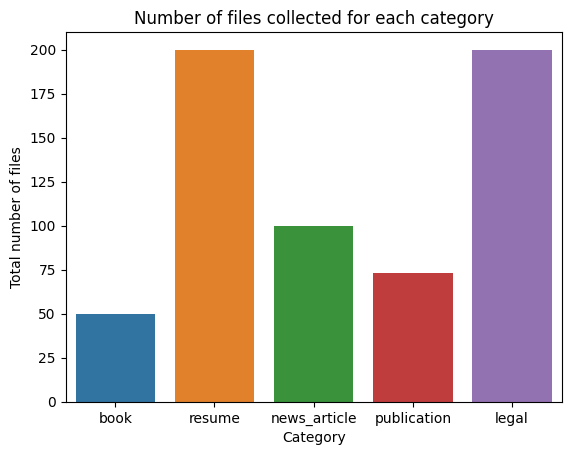

In [9]:
import seaborn as sns
ax = sns.countplot(x="category", data=data)
ax.set(xlabel='Category',
       ylabel='Total number of files',
       title='Number of files collected for each category')

# Embedding using Tfidf

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(cleaned_data['cleaned_text'].values, cleaned_data['category'].values,
                                                     test_size=0.3, random_state=123, stratify=cleaned_data['category'].values)

In [ ]:
X_train.shape, X_test.shape

((436,), (187,))

### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/Master Project 295A/models/tfidf_vectorizer.joblib')

['/content/drive/MyDrive/Master Project 295A/models/tfidf_vectorizer.joblib']

## Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(tfidf_train_vectors,y_train)
y_pred_rf = rf_classifier.predict(tfidf_test_vectors)

In [ ]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 600, num = 20)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 60, stop = 120, num = 10)],
               'bootstrap': [True, False],
               'min_samples_split': [5, 6, 7],
               'min_samples_leaf': [7, 8, 9],
               }

grid_rf = RandomizedSearchCV(RandomForestClassifier(), random_grid, cv = 3, n_iter = 60, verbose = 2, n_jobs = -1, random_state = 42)
grid_rf.fit(tfidf_train_vectors, y_train)

print("Best score:", grid_rf.best_score_)
print("Best estimator:", grid_rf.best_estimator_)
print("Best parameters: \n", grid_rf.best_params_)

best_params = grid_rf.best_params_

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best score: 0.974744134781924
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=93, min_samples_leaf=7,
                       min_samples_split=6, n_estimators=431)
Best parameters: 
 {'n_estimators': 431, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 93, 'bootstrap': False}


In [ ]:
model_rfc = RandomForestClassifier(n_estimators = 221, max_features = 'sqrt', max_depth = 120, 
                                   bootstrap = False, min_samples_leaf = 8, min_samples_split = 6)
model_rfc.fit(tfidf_train_vectors, y_train)

RandomForestClassifier(bootstrap=False, max_depth=120, min_samples_leaf=8,
                       min_samples_split=6, n_estimators=221)

In [ ]:
Y_pred_rfc = model_rfc.predict(tfidf_test_vectors)
predict_test_rfc = model_rfc.predict_proba(tfidf_test_vectors)

In [ ]:
# save the model to disk
filename = '/content/drive/MyDrive/Master Project 295A/models/rf_tfidf.pkl'
pickle.dump(rf_classifier, open(filename, 'wb'))

In [ ]:
cr_rfc = classification_report(y_test, Y_pred_rfc)
print(cr_rfc)

## Navies Bayes

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train_vectors.toarray(),y_train)
y_pred_nb = nb_classifier.predict(tfidf_test_vectors.toarray())

In [ ]:
print(classification_report(y_test,y_pred_nb))

## SVC

In [ ]:
svc_classifier = SVC(gamma='auto')
svc_classifier.fit(tfidf_train_vectors,y_train)
y_pred_svc = svc_classifier.predict(tfidf_test_vectors)

In [ ]:
print(classification_report(y_test,y_pred_svc))

# Embedding using Word2Vec

In [ ]:
X, y = cleaned_data.drop('category', axis = 1), cleaned_data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

data_train = pd.concat([X_train, y_train], axis = 1)
data_test = pd.concat([X_test, y_test], axis = 1)

In [ ]:
def convert_to_lowercase(text):
    return text.lower()

In [ ]:
# Relevant text normalization processes
regexp = RegexpTokenizer("[\w']+")

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

In [ ]:
for df in [data_train, data_test]:
    df['tokens'] = (df["cleaned_text"].apply(convert_contractions).apply(regexp.tokenize))
data_train[['tokens', 'category']].head()

In [ ]:
path = api.load("word2vec-google-news-300", return_path = True)
print(path)

In [ ]:
# Loading the pre-trained Word2Vec model
word2vec = gensim.models.KeyedVectors.load_word2vec_format(path, binary = True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

In [ ]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

In [ ]:
# Converting to Compressed Sparse Row matrix

X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

### Random Forest

In [ ]:
model_rfc = RandomForestClassifier(n_estimators = 100)
model_rfc.fit(X_train_w2v, y_train)

In [ ]:
y_pred_rf = model_rfc.predict(X_test_w2v)
print(classification_report(y_test,y_pred_rf))

### XGBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_w2v, y_train)

In [ ]:
y_pred_xgb = model_xgb.predict(X_test_w2v)
print(classification_report(y_test, y_pred_xgb))

### SVC

In [ ]:
model_svc = SVC(kernel='rbf', C = 1, gamma = 0.1)
model_svc.fit(X_train_w2v, y_train)
y_pred_svc = model_svc.predict(X_test_w2v)

cr_svc = classification_report(y_test, y_pred_svc)
print(cr_svc)

In [ ]:
param_svm = {'C':[0.1, 1, 10, 100, 1000],
             'kernel':['rbf', 'sigmoid', 'linear', 'poly'],
             'gamma': [1, 0.1, 0.01, 10, 100], 
             'degree': [0, 1, 2, 3, 4, 5, 6]
             }

grid_svc = RandomizedSearchCV(SVC(), param_svm, n_iter = 10, n_jobs = 4, cv = 5, random_state = 42)
grid_svc.fit(X_train_w2v, y_train)

print(grid_svc.best_score_)
print(grid_svc.best_estimator_)
print(grid_svc.best_params_)

In [ ]:
model_svc = SVC(kernel = 'rbf', gamma = 1, C = 100, degree = 4, probability = True)
model_svc.fit(X_train_w2v, y_train)

y_pred_svc = model_svc.predict(X_test_w2v)

cr_svc = classification_report(y_test, y_pred_svc)
print(cr_svc)

# Transformer Networks

### Tokenizer

In [ ]:
# path = '/content/drive/MyDrive/Master Project 295A/final text dataset/processed_files'  
# all_files = glob.glob(os.path.join(path, "*.csv"))        # advisable to use os.path.join as this makes concatenation OS independent
# df_from_each_file = (pd.read_csv(f)[:200] for f in all_files)
# concatenated_df   = pd.concat(df_from_each_file, ignore_index=True) 
# df = concatenated_df.drop(["Unnamed: 0"], axis=1)

In [ ]:
doc_dataset = data.copy()
doc_dataset.head()

,category,text,cleaned_text
0,book,﻿How can we free ourselves from mental sufferi...,how can we free ourselves from mental sufferin...
1,book,"﻿ The New Girl Webster Grove, Book 1 Tracie ...",the new girl webster grove book 1 tracie pucke...
2,book,﻿DEATH BY CHOCOLATE Copyright ©2011 Sally Bern...,death by chocolate copyright ©️2011 sally bern...
3,book,﻿ Always Know What to Say Easy Ways to Appro...,always know what to say easy ways to approach ...
4,book,﻿ A Little Bit of Déjà Vu The Return to Redem...,a little bit of deja vu the return to redempti...


In [ ]:
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Converting to datasets object

In [ ]:
doc_dataset_d = Dataset.from_pandas(doc_dataset)

In [ ]:
doc_datasettest_train = doc_dataset_d.train_test_split(test_size=0.1)
doc_datasettest_train

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'cleaned_text'],
        num_rows: 560
    })
    test: Dataset({
        features: ['category', 'text', 'cleaned_text'],
        num_rows: 63
    })
})

In [ ]:
doc_train = doc_datasettest_train['train']
doc_train

Dataset({
    features: ['category', 'text', 'cleaned_text'],
    num_rows: 560
})

In [ ]:
doc_test = doc_datasettest_train['test']
doc_test

Dataset({
    features: ['category', 'text', 'cleaned_text'],
    num_rows: 63
})

In [ ]:
categories = ['book', 'resume', 'legal', 'publication', 'news']

In [ ]:
prefix = f"Classify the following document into a one of the following topically semantic categories. Possible categories: {', '.join(categories)}. Document: "
print(prefix)

Classify the following document into a one of the following topically semantic categories. Possible categories: book, resume, legal, publication, news. Document: 


In [ ]:
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    if examples['category'] == 'news_article':
      cat = 'news'
    else:
      cat = examples['category']
    labels = tokenizer(text_target=cat, max_length=2, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_doc_train= doc_train.map(preprocess_function, batched=True)
tokenized_doc_test= doc_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

In [ ]:
print("-"*40 + " text " + "-"*40)
print(tokenized_doc_train[2]['text'])
print("-"*40 + " category " + "-"*40)
print("\n"+tokenized_doc_train[2]['category'])
print("-"*40 + " text TOKENS " + "-"*40)
print("\n"+ str(tokenized_doc_train[2]['input_ids']))
print("-"*40 + " processed text TOKENS " + "-"*40)
print(tokenizer.decode(tokenized_doc_train[2]['input_ids']))
print("-"*40 + " category TOKENS " + "-"*40)
print("\n"+ str(tokenized_doc_train[2]['labels']))
print("-"*40 + "Total tokenized train doc " + "-"*40)
print(len(tokenized_doc_train[2]['input_ids']))

---------------------------------------- text ----------------------------------------
Non-Disclosure Agreement
This Confidentiality and Non-Disclosure Agreement (hereinafter referred as the “NDA”) is entered into as of ,20 ,
by and between
_____________________, address at ________________________________________
and
Seeed Development Limited, a company established under Laws of Hong Kong, having its office at Flat C 23/F Lucky Plaza, 315-321 Lockhart Rd Wan Chai, Hong Kong (hereafter referred to as “Seeed”);
Unless the context requires otherwise, Customer and Seeed shall hereinafter collectively referred to as the “Parties” or individually referred to as the “Party”.
RECITALS
WHEREAS, Customer is
WHEREAS, Seeed is concerned any unpermitted early disclose or publicize of the products or any information associated with such products will cause irreparable harms to Seeed unless allowed by Seeed, therefore it is of necessity to conclude the NDA with Customer.
WHEREAS, In light of purpose

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
metrics_list = list_metrics()
print(metrics_list)

['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'character', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'Drunper/metrica_tesi', 'Felipehonorato/eer', 'GMFTBY/dailydialog_evaluate', 'GMFTBY/dailydialogevaluate', 'JP-SystemsX/nDCG', 'Josh98/nl2bash_m', 'KevinSpaghetti/accuracyk', 'NCSOFT/harim_plus', 'NikitaMartynov/spell-check-metric', 'NimaBoscarino/weat', 'Splend1dchan/cosine_similarity

In [ ]:
def my_compute_metrics(p: EvalPrediction):
    predictions = p.predictions
    references = p.label_ids
    print('preds',predictions)
    print('gt', references)
    return {'precision_score': 1}

### T5 MODEL

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Models/t5-small_1",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_doc_train,
    eval_dataset=tokenized_doc_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=my_compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.077796
2,No log,0.003269
3,No log,0.000597


TrainOutput(global_step=105, training_loss=1.2566420782180059, metrics={'train_runtime': 32.5149, 'train_samples_per_second': 51.669, 'train_steps_per_second': 3.229, 'total_flos': 227374226472960.0, 'train_loss': 1.2566420782180059, 'epoch': 3.0})

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Models/t5-small_kt')

In [ ]:
trainer.save('/content/drive/MyDrive/Models/t5-small_kt-2')

AttributeError: ignored

In [ ]:
tokenized_categories = [tokenizer.encode(cat)[0] for cat in categories]

In [ ]:
def classify_document(document: str, 
                   classes: List[str] = categories, 
                   class_tokens: List[int] = tokenized_categories,
                   model = model,
                   tokenizer = tokenizer) -> Tuple[str, Dict[str, float]]:
    prompt = prefix + document
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    inputs.to('cuda')
    outputs = model.generate(**inputs, return_dict_in_generate=True, output_scores=True, max_new_tokens=1, temperature=0)
    del(inputs)
    scores = [outputs.scores[0][:,t].cpu().numpy()[0] for t in class_tokens]
    scores = scipy.special.softmax(scores)
    return classes[np.argmax(scores)], {c: s for c,s in zip(classes, scores)}

In [ ]:
cat, cat_scores = classify_document("""TECHNICAL SKILLS
anoushka.gade@gmail.com ⋄ 669 306 2719 ⋄ LinkedIn ⋄ GitHub
Pandas, NumPy, Scikitlearn, Seaborn, Matplotlib, XGBoost, PyTorch, TensorFlow, NLTK, Spacy, HuggingFace, Transformers, BeautifulSoup, Scrapy, ServiceNow, JAX, Flask, REST, Git, Jenkins, NetworkX, Slurm, JIRA, Kubernetes, Airflow, Docker, Kibana, Tableau, Spotfire Python, R, Java, C, C++, LaTeX, Go, Bash, Shell Scripting, SQL (MySQL,PostgreSQL)
AWS, Azure, Hadoop, Spark, Databricks, Redshift, Elasticsearch, Flume, MongoDB, DynamoDB
 Frameworks
Languages Big Data
    """)

In [ ]:
cat, cat_scores

('resume',
 {'book': 0.0010714035,
  'resume': 0.9710886,
  'legal': 9.23415e-05,
  'publication': 0.027623627,
  'news': 0.00012400291})

In [ ]:
preds = []
targets = []
for i, example in enumerate(tokenized_doc_test):
    pred, _ = classify_document(example['text'])
    target = example['category'] if example['category'] != 'news_article' else 'news'
    preds.append(pred)
    targets.append(target)
    if i % 100 == 0:
        print(i)

0


In [ ]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

        book       1.00      1.00      1.00         7
       legal       1.00      1.00      1.00        20
        news       1.00      1.00      1.00         8
 publication       1.00      1.00      1.00         9
      resume       1.00      1.00      1.00        19

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



In [ ]:
cat, cat_scores = classify_document("""T{"question": "what does normalizing text mean", "answers": ["converting it to a more convenient, standard form"]}
    """)
print(cat, cat_scores)

resume {'book': 0.0037918587, 'resume': 0.89386636, 'legal': 0.0067939595, 'publication': 0.07555398, 'news': 0.019993901}


In [ ]:
cf_matrix = confusion_matrix(targets, preds)
cf_matrix

array([[ 7,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [ 0,  0,  8,  0,  0],
       [ 0,  0,  0,  9,  0],
       [ 0,  0,  0,  0, 19]])

## BERT

In [ ]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Load the cleaned data
X = cleaned_data['cleaned_text'].values
y = cleaned_data['category'].values

# Convert the text data to tokens
max_len = 200
X_tokenized = tokenizer(X.tolist(), padding=True, truncation=True, max_length=max_len)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tokenized['input_ids'], y, test_size=0.1, random_state=42)

# Create TensorFlow datasets for the training and validation sets
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_train}, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_val}, y_val)).batch(batch_size)

# Compile the model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Fine-tune the model on the training set
history = bert_model.fit(train_dataset, epochs=1, validation_data=val_dataset)

# Evaluate the model on the validation set
loss, accuracy = bert_model.evaluate(val_dataset)
print(f"Validation loss: {loss:.4f}, Validation accuracy: {accuracy:.4f}")

4/4 [==============================] - 1s 227ms/step - loss: 0.4433 - sparse_categorical_accuracy: 1.0000
Validation loss: 0.4433, Validation accuracy: 1.0000


In [ ]:
y_out = bert_model.predict(val_dataset)
print(classification_report(y_val, np.argmax(y_out[0], axis=1)))

4/4 [==============================] - 4s 217ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        24

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63

